# Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA



#Read in data.  Zipcode is string to keep leading 0's
raw_data = pd.read_csv('Zillow_data/zhvi_all-homes_zipcode.csv', dtype={'RegionName': object})
raw_data.head(3)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,233265.0,...,1248340.0,1234262.0,1229890.0,1226466.0,1208024.0,1182758.0,1150900.0,1134880.0,1120949.0,1112549.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,211748.0,...,494425.0,493485.0,492514.0,491726.0,491562.0,492618.0,494017.0,494766.0,494546.0,494435.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,245773.0,...,1161916.0,1153259.0,1156287.0,1175142.0,1193746.0,1205413.0,1203165.0,1209735.0,1211403.0,1212520.0


In [2]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30443 entries, 0 to 30442
Columns: 303 entries, RegionID to 2020-06-30
dtypes: float64(294), int64(2), object(7)
memory usage: 70.4+ MB


# Cleaning & Preprocessing Functions

In [3]:
def melt_data(df):
    """
    """
    melted = pd.melt(df, id_vars=['zipcode', 'City', 'State', 'CountyName', 'Metro'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [4]:
def clean_data(df):
    """
    """
    #rename RegionName to 'zipcode'
    df.rename(columns={'RegionName': 'zipcode'}, inplace=True)
    
    #drop unneeded columns
    df.drop(columns=['RegionID', 'RegionType', 'StateName', 'SizeRank'], inplace=True)
    
    #Change to long format
    df_long = melt_data(df)
    
    #Non-metro zipcodes now called 'rural'
    df_long.fillna('rural', inplace=True)
    
    return df_long

# Processing & Visualization Functions

In [6]:
def get_codes_data(df, codes):
    """
    """
    #Filter df to keep data for selected zipcodes
    top_df = df[df['zipcode'].isin(codes)]
    
    #Set time as index
    top_df.set_index('time', inplace=True)
    
    #Drop unneeded columns
    top_df = top_df[['zipcode', 'value']]
    
    return top_df

In [7]:
def split_data_by_code(top_df, codes):
    """
    """
    df_list = []
    for i in range(len(codes)):
        df_list.append(top_df.loc[top_df['zipcode'] == codes[i]])
        
    return df_list

In [8]:
def plot_trends(df_list, codes):
    """
    """
    colors = ['indianred', 'teal', 'orange', 'mediumpurple', 'cornflowerblue']
    for i in range(len(codes)):
        df_list[i]['value'].plot(label=codes[i], figsize=(15, 6), color=colors[i])
        plt.legend()

# Modeling Functions

In [11]:
def get_difference(df_list):
    df_diff = []

    for code in df_list:
        df_diff.append(code['value'].diff().diff().dropna())

    return df_diff

In [12]:
def plot_diff_trends(diff_list, codes):
    #Graph trends
    colors = ['indianred', 'teal', 'orange', 'mediumpurple', 'cornflowerblue']
    for i in range(len(codes)):
        diff_list[i].plot(label=codes[i], figsize=(15, 6), color=colors[i])
        plt.legend()

In [13]:
def decompose_graphs(diff_list, codes):
    for i in range(len(codes)):
        decomposition = seasonal_decompose(diff_list[i])
        print(codes[i] + ": ")
        fig = plt.figure()
        fig = decomposition.plot()
        fig.set_size_inches(15, 8)

In [14]:
def test_stationarity(timeseries, window):

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [15]:
def test_station_of_list(diff_list, window):
    for i in range(len(diff_list)):
        test_stationarity(diff_list[i], window)
        

In [25]:
def plot_all_pacf(diff_list, codes):
    for i in range(len(diff_list)):
        plot_pacf(diff_list[i], title=codes[i]);

In [27]:
def plot_all_acf(diff_list, codes):
    for i in range(len(diff_list)):
        plot_acf(diff_list[i], title="ACF" + codes[i]);

In [29]:
def fit_arima(data, model_list, pred_list, ar, diff, ma):
#     model_data = data.drop('zipcode', axis=1)
    model = ARIMA(data, (ar,diff,ma)).fit()
    model_list.append(model)
    pred_list.append(model.predict(typ='levels'))
    
    return model_list, pred_list

# Data Cleaning

In [ ]:
df = clean_data(raw_data)

# Modeling - Top 5 Codes Since 1996

### Preprocessing & Viz

In [9]:
codes_full_range = ['91108', '90211', '90027', '90266', '94610']
top_full_range = get_codes_data(df, codes_full_range)
fr_list = split_data_by_code(top_full_range, codes_full_range)

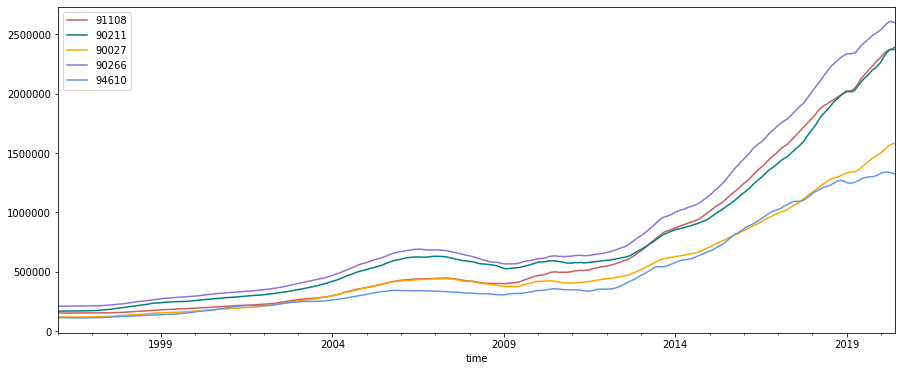

In [10]:
plot_trends(fr_list, codes_full_range)

### Assumptions & Best Parameters

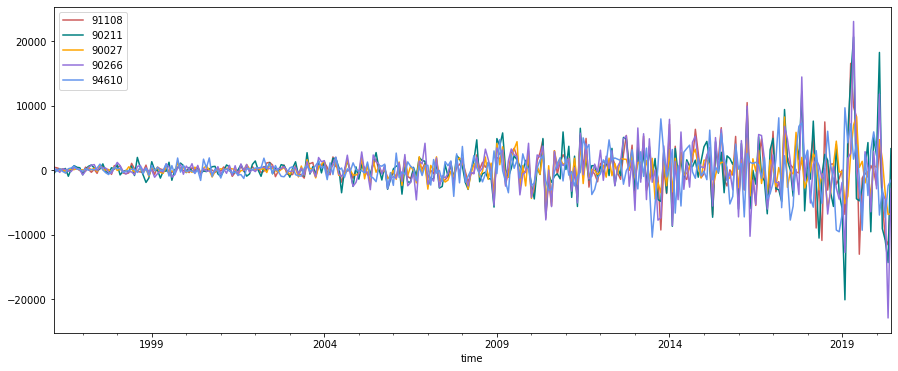

In [18]:
fr_diff = get_difference(fr_list)
plot_diff_trends(fr_diff, codes_full_range)

In [21]:
test_station_of_list(fr_diff, 12)

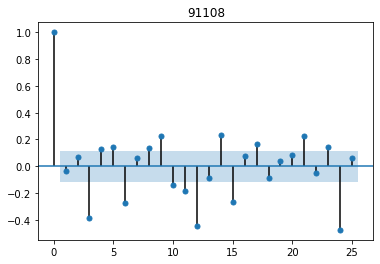

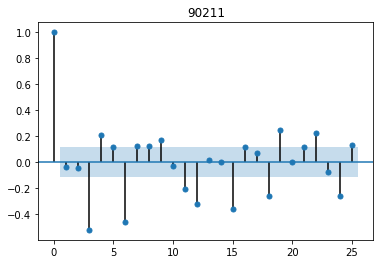

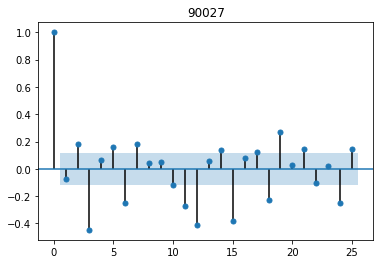

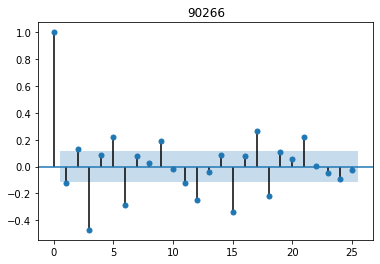

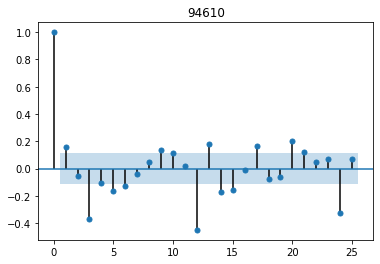

In [26]:
plot_all_pacf(fr_diff, codes_full_range)

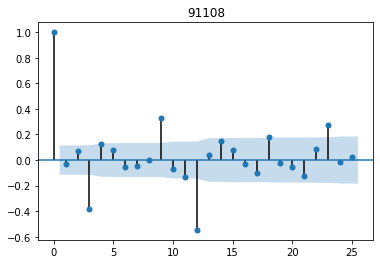

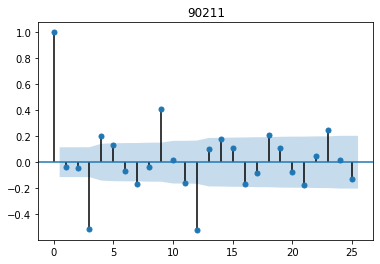

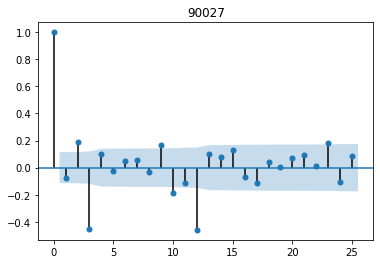

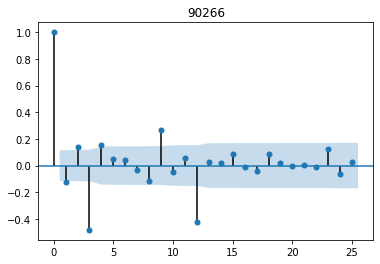

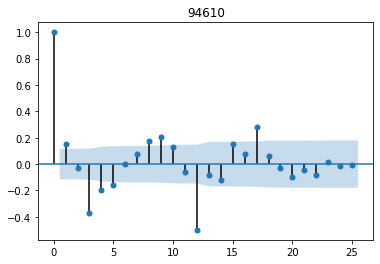

In [28]:
plot_all_acf(fr_diff, codes_full_range)